In [1]:
# import libraries
# Always run this cell first!
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import powerlaw
from scipy import integrate
from scipy.integrate import odeint
import math
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import cnames
from matplotlib import animation
import scipy
import statsmodels.api # appear to need to import the api as well as the library itself for the interpreter to find the modules
import statsmodels as sm
from matplotlib import ticker
import seaborn as sns
import plotly.graph_objects as go
import plotly.offline
plotly.offline.init_notebook_mode(connected=True) # make plotly work with Jupyter Notebook using CDN

# an extra function for plotting a straight line
def plot_abline(slope, intercept, color = None, x_name = "x", y_name = "y"):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(
        x_vals, y_vals, '--', color = color,
        label = f"${y_name} = {slope:.2f}{x_name} " + ("-" if intercept < 0 else "+") + f"{abs(intercept):.2f}$"
    )
# an extra function for plotting a straight line
def plot_abline(slope, intercept, color = None, x_name = "x", y_name = "y"):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(
        x_vals, y_vals, '--', color = color,
        label = f"${y_name} = {slope:.2f}{x_name} " + ("-" if intercept < 0 else "+") + f"{abs(intercept):.2f}$"
    )

# Complex Systems Lab

## 1. Bifurcations in the Rozenzweig-MacArthur Predator Pray (RMPP) Equations

In this section will look at Rozenzweig-MacArthur Predator-Prey (RMPP) Equations

(For background, see
https://staff.fnwi.uva.nl/a.m.deroos/projects/QuantitativeBiology/43-HopfPoint-Rosenzweig.html)



**Defining the equations**
RMPP is a 2D nonlinear system of ODEs 

$$
    \frac{dF}{dt}  =  rF(1-\frac{F}{K}) - \frac{aF}{1+ahF}C
$$

$$
    \frac{dC}{dt} =  \epsilon \frac{aF}{1+afF}C-\mu C
$$

where:

$F=$ prey density (eg rabbits)
 
$C=$ predator density (eg foxes)

$\frac{dF}{dt}$ = dynamic change of prey 

$\frac{dC}{dt}$ = dynamic change of predator

$r$ = prey natural growth rate

$K$ = prey carrying capacity

$a$ = attack rate

$h$ = handling rate (predator needs h time units to consume prey)

$e$ = prey offspring proportionality constant to $F$

$\mu$ - predator death rate

The following cell simulates the solution to RMPP over the time interval $0\le t\le 500$ with parameter values $r=.5,K=.05, a=5, h=3, e=.5, \mu=.1$


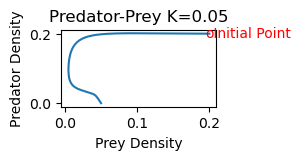

In [2]:

# timestep determines the accuracy of the euler method of integration
timestep = 0.001
# amplitude of noise term
amp = 0.
# the time at which the simulation ends
end_time = 500

# creates a time vector from 0 to end_time, seperated by a timestep
t = np.arange(0,end_time,timestep)

# intialize rabbits (x) and foxes (y) vectors
x = []
y = []

"""" parameters"""

K=.05
r = .5
a=5
h=3
e=.5
m=.1

""" euler integration """

# initial conditions for the rabbit (x) and fox (y) populations at time=0
x0=.2
y0=.2
x.append(x0)
y.append(y0) 

# forward euler method of integration
# a perturbbation term is added to the differentials to make the simulation stochastic
for index in range(1,len(t)):
    
    # evaluate the current differentials
    xd = r*x[index-1]*(1-x[index-1]/K) - a * x[index-1]*y[index-1]/(1+a*h*x[index-1])
    yd = e*a*x[index-1]*y[index-1]/(1+a*h*x[index-1])-m*y[index-1]
    
    # evaluate the next value of x and y using differentials
    next_x = x[index-1] + xd * timestep
    next_y = y[index-1] + yd * timestep
    
    x.append(next_x)
    y.append(next_y)

""" visualization """

if amp == 0:    
    # visualization of deterministic populations against time
    plt.figure(figsize=(2,1))
    plt.plot(x, y)
    plt.text(x0,y0,'o',ha='center', va='center',color='r')
    plt.text(x0,y0,' Initial Point',ha='left', va='center',color='r')
    plt.ylabel('Predator Density')
    plt.xlabel('Prey Density')
    plt.title('Predator-Prey K='+str(K))
    plt.show()

Note that the predators grow extinct and the prey density approaches a value of approximately .05.

References:
https://staff.fnwi.uva.nl/a.m.deroos/projects/QuantitativeBiology/43-HopfPoint-Rosenzweig.html

Anthony Hills, https://github.com/INASIC/predator-prey_systems/blob/master/Modelling%20Predator-Prey%20Systems%20in%20Python.ipynb


### Exercises

```{admonition} Exercises
1 a) Define a function rmpp(x0,y0,K) which whose inputs specify the initial point (x0,y0) and prey carrying capacity K and whose ouput is a graph of  the solution to the RMPP equations for $0\le t \le 500$.

b) Check that your output for rmpp(.2,.2,.05) agrees with the above plot.

2. a) Make a chart showing the solution behavior as K is increased to .15, .25 and .3.
(Note: for k=.3, also check the solution behavior for (x0,y0)=(.1,.15))
b) Describe the difference in the solution behavior for these K values.

3) Explain why RMPP has a Hopf bifurcation (one in which there is a critical value at which a stable equilibrium becomes unstable and a stable periodic solution is created.)
```

## 2. Sensitive Dependence on Initial Conditions in a Fitzhugh Nagumo System

Imagine you are a new grad student. You are interested in applied math so are taking a course in ordinary differential equations (ODEs). One day, your professor talks about his colleague Dr. John Rinzel, who at the time was head of the math research branch at NIH (National Institutes of Health). Dr. Rinzel is an expert in mathematical neurobiology, and has developed several models of how neurons fire (active phase) and then relax (interval of quiescence). One of the nonlinear models he investigated is a 3 dimensional ODE system which we will refer to as the Fizhugh-Nagumo system (FHN):

$$
\frac{dv}{dt}  = v-v^3/3-w+y+I 
$$

$$
\frac{dw}{dt}  = \phi(v+a-bw)  
$$

$$
\frac{dy}{dt} = \theta(-v+c-dy)
$$

$v(t)$ is a membrane voltage variable which spikes when the neuron fires. $w(t)$ represents the activity of several membrane channel proteins which help facilitate the neuron's firing.  The parameter I is a bifurcation parameter corresponding to the magnitude of the stimulus current.  The underlying 2D system (without the variable $y$) undergoes a Hopf bifurcation.  For $I<I_{crit}$, there is a stable spiral equilibrium point  which corresponds to the interval of quiescence. For $I<I_{crit}$, the equilibrium point loses its stability as there is a stable periodic solution which corresponds to the spiking of $v$ during the active phase.

Note that in the 3D system,if I is fixed, the inclusion of y(t) will effectively move the 2D system back and forth across the bifurcation point of the 2D system.

Using  parameter values and initial point specified by Dr. Rinzel, we solve the FHN system numerically and plot the solution to to see the action potentials.

In [3]:
def solve_FHN(x0,N=10, max_time=1000.0, I=.3125, phi=.08, theta=.0006,a=.7,b=.8,c=-.775,d=1):

    def FHN_deriv(v_w_y,t0=0, x0=x0,phi=phi, theta=theta, I=I,a=a,b=b,c=c,d=d):
        """Compute the time-derivative of a FHN system."""
        v, w, y = v_w_y
        return [v-v**3/3-w+y+I, phi*(v+a-b*w),theta*(-v+c-d*y) ]

    # Solve for the trajectories
    t = np.linspace(0, max_time, int(250*max_time))
    x_t = integrate.odeint(FHN_deriv, x0, t)
    
    return t, x_t

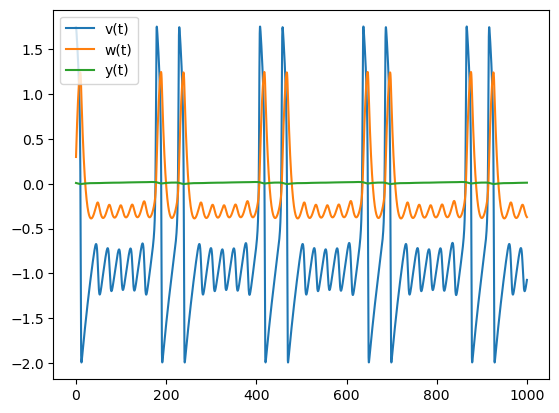

In [4]:
[t,x_t]=solve_FHN([1.744,.298,.00872]) # Initial conditions v=1, w=0, y=0.
plt.plot(t,x_t)
plt.legend(["v(t)","w(t)","y(t)"])
plt.savefig("FHN1.png")

The periodic oscillation for v(t) has a stable burst pattern denoted 1100000 meaning that two large spikes (11) followed by five small oscilations (ooooo) and this pattern will recur over and over.

### Exercise

```{admonition} Exercise
1. Explain how the bursting behavior in FHN is related to a Hopf bifurcation in the underlying 2D system.

2. Nonlinear ODE systems can exhibit complex behavior such as sensitive dependence on initial conditions.

a) Re-simulate FHN using the same paramter values and the initial condition  x0=[1.725,.337,.00764]. What do you observe? 
b) Why does FHN exhibit sensitive dependence on initial conditions and how does FHN exhibit this?
```

## 3. Random Walks

 A random walk  beginning at $x_0=0$, is such that $x_t$, the position at timestep $t=0,1,2,...$ is

$$
x_{t+1}=x_t+e_t
$$

where $e_t=\pm 1$ with equal probability. The random variables $e_t$ and $e_{t'}$ ($t\neq t')$ are assumed to be independent and identically distributed (IID).

The following cell simulates a random walk.


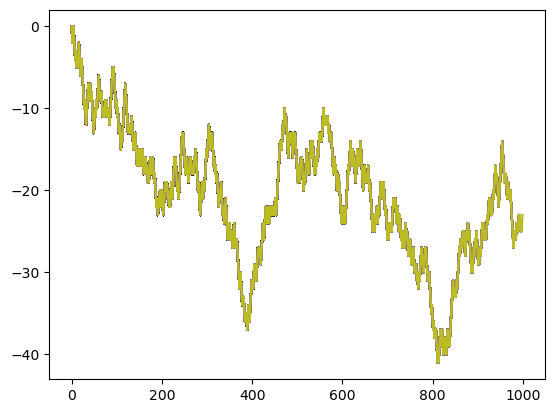

In [5]:
x=[0]
t=[0]
for i in np.arange(1,1000,1):
    x.append(x[i-1]+random.choice((-1, 1)))
    t.append(i)
    plt.plot(t,x)

Although each individual random walk is completely unpredictable, a large ensemble of random walks has a predictable structure since

$$
<x_t>=0
$$

$$
<x_t^2>=t
$$

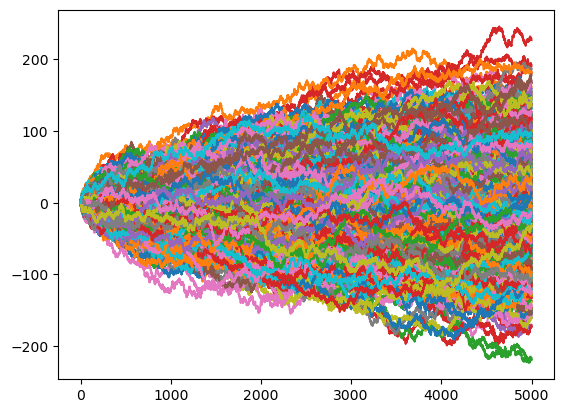

In [6]:
x=[0]
t=[0]
xf=[]
xf2=[]
for run in np.arange(0,1000):
    for i in np.arange(1,5000,1):
        x.append(x[i-1]+random.choice((-1, 1)))
        t.append(i)
    xf.append(x[4999])
    xf2.append(x[4999]**2)
    plt.plot(t,x)
    x=[0]
    t=[0]

Note that after 5000 steps, the mean for 1000 random walks of $x_t$ (t=4999) is close to 0, and the mean of $x_t^2$ is close to t. In other words, for a normal random walk with $x_t=0$, the mean is zero ($<x_t>=0$)  and the variance grows linearly with $t$ ($<x_t^2>=t$):

In [7]:
print("Mean of x[4999]=", np.mean(xf))
print("Mean of x[4999]^2=", np.mean(xf2))

Mean of x[4999]= 2.814
Mean of x[4999]^2= 4909.936


Here is a graph of a 2D random walk with 1000 steps (both the x position and y position are random walks.)

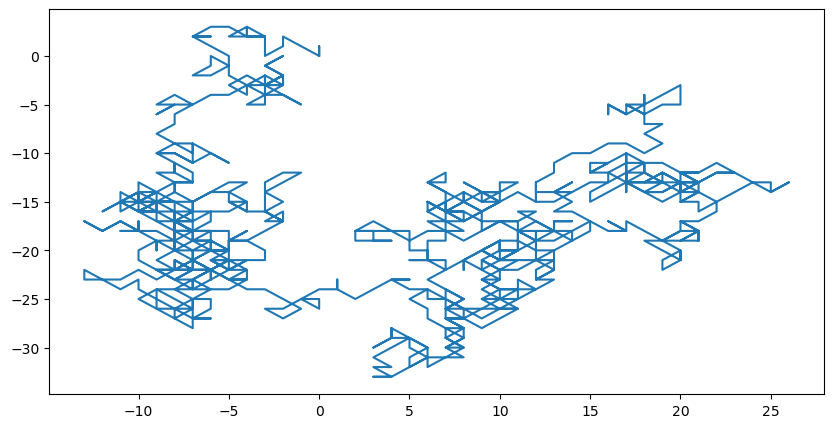

In [8]:
# Set seed for reproducible results (optional)
np.random.seed(10)

# Initial particle position
current_xpos = 0
current_ypos = 0

# Initial list of positions
x = [current_xpos]
y = [current_ypos]

# Define number of particle steps
N = 1000

# Generate set of random steps in advance (it could also be done inside the for loop)
xstep = np.random.randint(-1,2,N)
ystep = np.random.randint(-1,2,N)

# Iterate and track the particle over each step
for i in range(N):
    
    # Update position
    current_xpos += xstep[i]
    current_ypos += ystep[i]
    
    # Append new position
    x.append(current_xpos)
    y.append(current_ypos)
    
# Plot random walk
plt.figure(figsize=(10,5))
plt.plot(x, y)

plt.show()    

**Brownian Motion**

We can also create a random walk using variable step sizes by drawing from a standard normal distribution (np.random.normal(0, 1, 1000))

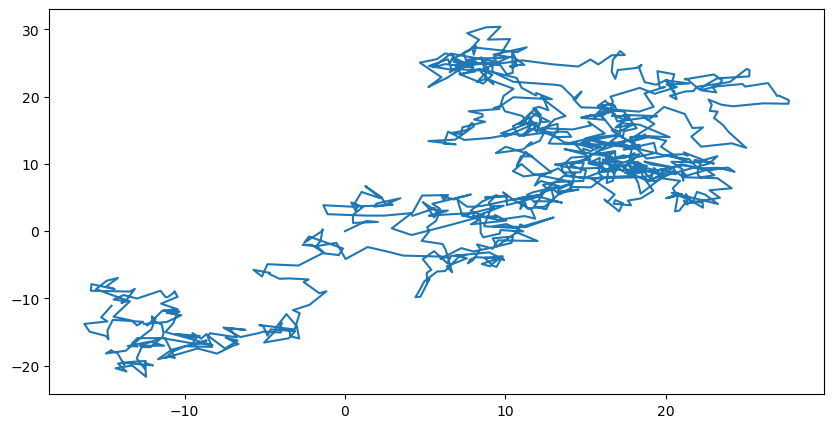

In [9]:
# Set seed for reproducible results (optional)
np.random.seed(10)

# Initial particle position
current_xpos = 0
current_ypos = 0

# Initial list of positions
x = [current_xpos]
y = [current_ypos]

# Define number of particle steps
N = 1000

# Generate set of random steps in advance (it could also be done inside the for loop)
xstep = np.random.normal(0,1,N)
ystep = np.random.normal(0,1,N)

# Iterate and track the particle over each step
for i in range(N):
    
    # Update position
    current_xpos += xstep[i]
    current_ypos += ystep[i]
    
    # Append new position
    x.append(current_xpos)
    y.append(current_ypos)
    
# Plot random walk
plt.figure(figsize=(10,5))
plt.plot(x, y)

plt.show()    

#### Exercise

```{admonition} Exercise

1. a) A standard Cauchy distribution  with p.d.f. $f(x)=\frac{1}{\pi(1+x^2)} is a heavy tail distribution with $<x>=0$ and infinite variance. Simulate a 2D random walk  with $N=1000$ steps where each step is determined by a random draw from a Cauchy distribution (np.random.standard_cauchy(N)).

b) What difference do you notice about this random walk compared with brownian motion.

2. a) Plot the probability density function of a standard Cauchy distribution and a standard normal distribution.  Explain why the former is said to have a heavy tail.  

b) What is the significance of 'long flights' in Cauchy random walks?
```

## 4. Scale Adjusted Metropolitan Index (SAMI)

Urban scaling theory conceptualizes cities as interdependent socioeconomic and spatial (infrastructural) networks that coevolve to support each other. Major goals include:

<ul>
<li>Find empirical characteristics of cities as a whole (extensive properties) such as GDP or road surface area which exhibit scale invariant relations (vary on average with city size).</li>
    <li>develop an urban scaling theory to explain the observed patterns</li>
    <li>develop predictive models</li>
</ul>

An extensive property of cities has the form 

$$
Y(N_i(t),t) = Y_i(t)=Y_0(t)N_i(t)^{\beta} e^{\xi_i(t)}>0
$$

<ul>
 <li>$i=1,...,N_c$ correspond to cities</li>
<li>$N_i$ is a measure of system size varies continuously with time $t$</li>
<li>$Y_0(t)$ is a prefactor independent of scale</li>
<li> $\beta$ is a scaling exponent (elasticity) expressing the average relative percentage change in $Y$ given a percentage variation in $N$ at a fixed time $t$.</li>
   
$$
       \beta=\frac{\frac{dY}{Y}}{\frac{dN}{N}}
$$

<li>$\xi_i(t)$ are residuals which account for deviations of city $i$ from the average scaling pattern of all cities. The residuals satisfy</li>
    
$$
\sum_{i=1}^{N_c} \xi_i=0.
$$
    
<li>Scaling laws arise when the variance $\sigma^2=\frac{1}{N_c}\sum_{i=1}^{N_c} \xi_i^2$ is scale independent.</li>
</ul>

**Scaling laws**

A socio-economic variable ($Y$) follows a population ($N$) scaling law if

$$
    Y(N)=G N^{\beta}
$$

with $G>0$ and $\beta$ are constants independent of the value of $N$.

**Example**

GDP of cities in China.

In [10]:
chinagdp = pd.read_excel('chinaGDP.xlsx')
chinagdp.head()

,City,Pop,GDP
0,Shanghai,26875500,664
1,Beijing,21167303,619
2,Shenzhen,17633800,482
3,Chongqing,12313714,433
4,Guangzhou,18810600,429


In [11]:
for i in chinagdp.index:
    chinagdp.loc[i,"LnPop"]=np.log( chinagdp.loc[i,"Pop"])
    chinagdp.loc[i,"LnGDP"]=np.log( chinagdp.loc[i,"GDP"])
chinagdp.shape


(29, 5)

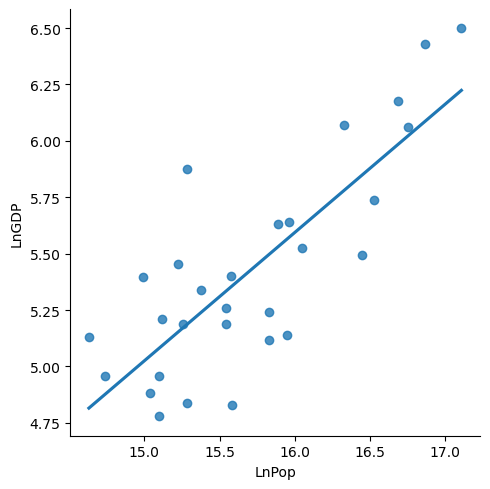

In [12]:
sns.lmplot(
    data = chinagdp,
    x = 'LnPop',
    y = 'LnGDP',
    ci = None
);

In [13]:
x = 'LnPop'
y = 'LnGDP'

lin_mod = sm.regression.linear_model.OLS(
    chinagdp[y], # the dependent variable (y)
    sm.tools.tools.add_constant(chinagdp[x]) # the independent variable (x)
)

results = lin_mod.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  LnGDP   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     47.51
Date:                Wed, 20 Dec 2023   Prob (F-statistic):           2.09e-07
Time:                        14:52:22   Log-Likelihood:                -4.2813
No. Observations:                  29   AIC:                             12.56
Df Residuals:                      27   BIC:                             15.30
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.5082      1.298     -2.703      0.0

Note that the data for China has 𝛽=.5689.


Text(0.5, 1.0, 'SAMI with Trend Line')

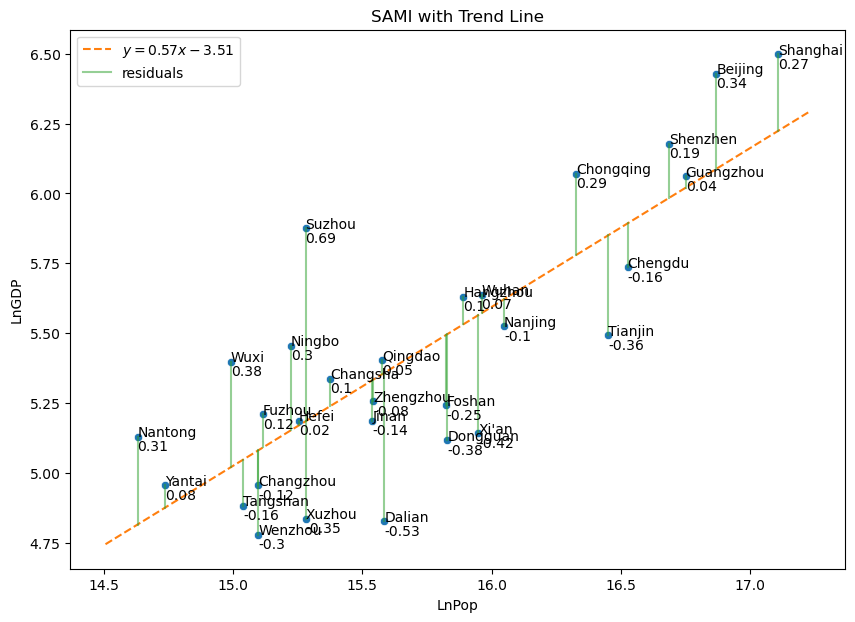

In [14]:
fig, axes = plt.subplots(1,1, sharex = True, sharey = True, figsize = (10,7))
slopes = [.5689]
intercepts = [-3.5082]
(scattercolor, trendcolor, residcolor) = sns.color_palette()[0:3]
# plot data
sns.scatterplot(
    data = chinagdp,
    x = 'LnPop',
    y = 'LnGDP',
    color = scattercolor,
    )
# plot the line with given slope and intercept
plot_abline(slopes[0], intercepts[0], color = trendcolor)
# plot residuals
for j, (x, y) in enumerate(zip(chinagdp['LnPop'], chinagdp['LnGDP'])):
    plt.plot(
        [x, x], [y, slopes[0]*x + intercepts[0]],
        color = residcolor, alpha = 0.5,
        label = "residuals" if j == 0 else "" # show legend entry only for first residual in each plot
    )
for j, (x, y) in enumerate(zip(chinagdp['LnPop'], chinagdp['LnGDP'])):
    plt.text(x,y,chinagdp.loc[j,"City"])
    plt.text(x,y-.05,str(np.round(y-(slopes[0]*x + intercepts[0]),2)))
plt.legend(loc = "upper left")
plt.savefig("ChinaSAMI.png")
plt.gca().set_title(f"SAMI with Trend Line")

### Exercise

```{admonition} Exercise
Where would Hong Kong fall if added to the SAMI graph above?
```